In [2]:
import torch
import numpy as np
from config.path import STORAGE
from transmittance2fom_genmodels.notebooks.dataloaderEX4 import create_paired_dataloader
from transmittance2fom_genmodels.notebooks.image2image_model_EX4 import Generator
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats

def load_trained_generator(device):
    """Load the trained generator from a checkpoint."""
    generator = Generator().to(device)
    generator.load_state_dict(torch.load(STORAGE / "image2image" / "generator.pth"))
    generator.eval()
    return generator

def calculate_metrics(generated, target):
    """Calculate MSE, SSIM, and PSNR for a pair of images."""
    # Convert from [-1,1] to [0,1] range for generated images
    generated = (generated + 1) / 2.0
    generated = np.clip(generated, 0, 1)
    
    mse_val = mean_squared_error(target, generated)
    
    # Calculate SSIM for each channel and take mean
    ssim_val = np.mean([ssim(target[:,:,i], generated[:,:,i], data_range=1.0) 
                       for i in range(target.shape[2])])
    
    # Calculate PSNR
    psnr_val = psnr(target, generated, data_range=1.0)
    
    return mse_val, ssim_val, psnr_val

def evaluate_generator(generator, test_loader, device, num_samples=1000):
    """Evaluate generator on test data using multiple metrics."""
    mse_scores = []
    ssim_scores = []
    psnr_scores = []
    
    generator.eval()
    processed_samples = 0
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Evaluating")
        for batch in pbar:
            input_trans = batch['input'].to(device)
            target_fom = batch['target']
            
            # Generate FOMs
            generated_fom = generator(input_trans)
            
            # Process each sample in the batch
            for i in range(input_trans.size(0)):
                if processed_samples >= num_samples:
                    break
                    
                # Convert to numpy arrays and correct format
                gen_fom = generated_fom[i].cpu().permute(1, 2, 0).numpy()
                target = target_fom[i].permute(1, 2, 0).numpy()
                
                # Calculate metrics
                mse, ssim_val, psnr_val = calculate_metrics(gen_fom, target)
                
                mse_scores.append(mse)
                ssim_scores.append(ssim_val)
                psnr_scores.append(psnr_val)
                
                processed_samples += 1
                
            if processed_samples >= num_samples:
                break
                
            pbar.set_postfix({
                'Processed': f'{processed_samples}/{num_samples}'
            })
    
    # Convert to numpy arrays
    mse_scores = np.array(mse_scores)
    ssim_scores = np.array(ssim_scores)
    psnr_scores = np.array(psnr_scores)
    
    # Calculate statistics
    stats_dict = {
        'MSE': {
            'mean': np.mean(mse_scores),
            'std': np.std(mse_scores),
            'scores': mse_scores
        },
        'SSIM': {
            'mean': np.mean(ssim_scores),
            'std': np.std(ssim_scores),
            'scores': ssim_scores
        },
        'PSNR': {
            'mean': np.mean(psnr_scores),
            'std': np.std(psnr_scores),
            'scores': psnr_scores
        }
    }
    
    return stats_dict

def plot_metric_distributions(stats_dict):
    """Plot histograms of metric distributions."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, (metric, data) in zip(axes, stats_dict.items()):
        scores = data['scores']
        mean = data['mean']
        std = data['std']
        
        ax.hist(scores, bins=30, density=True, alpha=0.7)
        ax.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.4f}')
        
        # Plot normal distribution
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mean, std)
        ax.plot(x, p, 'k', linewidth=2, label=f'Std: {std:.4f}')
        
        ax.set_title(f'{metric} Distribution')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


Using device: mps:0


/var/folders/4g/91bm8hl51ld9v8c8tg6_lrqw0000gn/T/ipykernel_38729/1174280426.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(STORAGE

Successfully loaded trained generator
Calculating metrics across 1000 samples...


Evaluating:  99%|█████████▉| 124/125 [00:19<00:00,  6.47it/s, Processed=992/1000]



Evaluation Results:
--------------------------------------------------
MSE:
  Mean: 0.1519
  Std:  0.0120
SSIM:
  Mean: 0.2041
  Std:  0.0209
PSNR:
  Mean: 8.1973
  Std:  0.3331


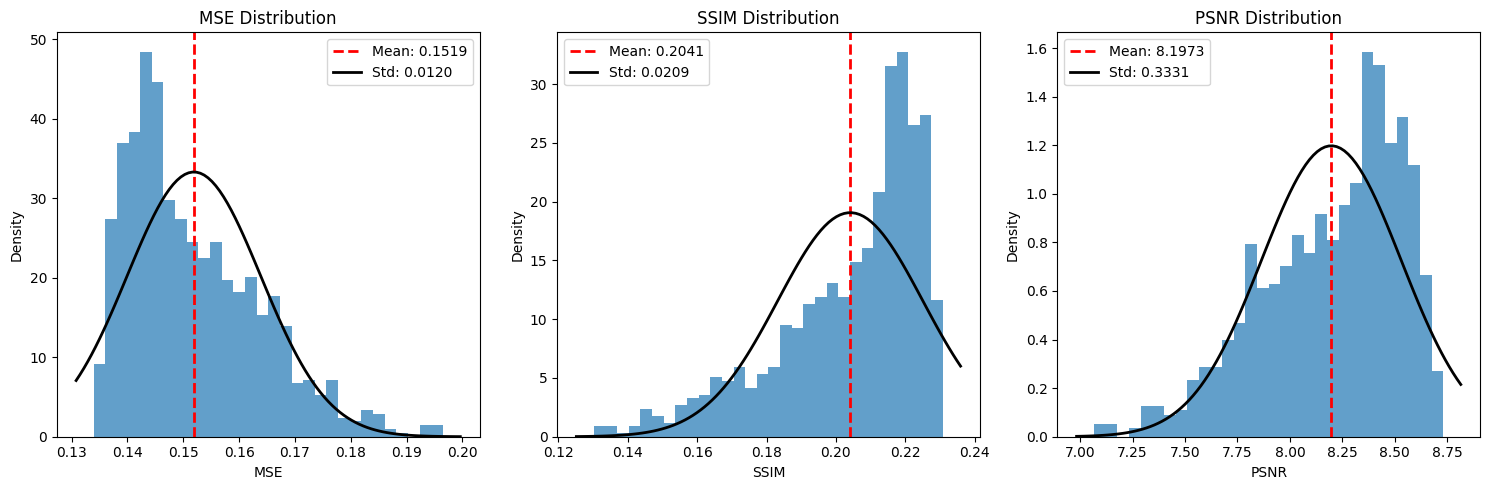

In [7]:
from config.path import VERVET_DATA, STORAGE
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps:0")
    print(f"Using device: {device}")
    
    # Set paths
    data_dir = VERVET_DATA
    checkpoint_path = STORAGE / "image2image" / "pix2pix_checkpoint_epoch_20.pth"  # Adjust epoch number as needed
    
    # Create test dataloader for Vervet1947
    test_loader = create_paired_dataloader(
        data_dir=data_dir,
        brain="Vervet1947",
        patch_size=256,
        batch_size=8,
        tiles_per_epoch=1000,
        num_workers=0
    )
    
    try:
        # Load trained generator
        generator = load_trained_generator(device)
        print("Successfully loaded trained generator")
        
        # Evaluate generator
        print("Calculating metrics across 1000 samples...")
        stats_dict = evaluate_generator(generator, test_loader, device)
        
        # Print results
        print("\nEvaluation Results:")
        print("-" * 50)
        for metric, data in stats_dict.items():
            print(f"{metric}:")
            print(f"  Mean: {data['mean']:.4f}")
            print(f"  Std:  {data['std']:.4f}")
        
        # Plot distributions
        plot_metric_distributions(stats_dict)
        
    except FileNotFoundError as e:
        print(f"Error: Could not find checkpoint file at {checkpoint_path}")
        print("Please ensure you have trained the model and have the correct checkpoint file path")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        
        
main()